# Anchor-Probe Hidden Distance
**Goal**: Analyze the distance between the hidden representation of each set of anchors and their probes

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Data

In [2]:
LAYER = 'hidden'

In [3]:
# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_20210729.pkl')
anchor_probe_mapping = anchor_probe_mapping.rename(columns={'probes': 'probe'})
anchor_probe_mapping.head()

,anchors,probe,type
0,"[bive, kive, tive]","[zive, mive, pive, rive]",AMB
1,"[blome, prome, thome]","[shome, flome, grome, chome]",AMB
2,"[clead, smead, pread]","[snead, glead, thead, kread]",AMB
3,"[frow, clow, spow]","[zow, trow, fow, smow]",AMB
4,"[grour, snour, frour]","[brour, drour, prour, trour]",AMB


In [4]:
all_anchors_data = []
all_probes_data = []
anchor_list = sum(anchor_probe_mapping['anchors'].tolist(), [])

for dilution in tqdm(range(1, 4)):
    for partition in range(3):
        # ANCHORS
        
        anchor_types = [f"ANC_{i}" for i in ['REG', 'EXC', 'AMB']]

        anchor_data = pd.read_pickle(f'cogsci-recurrent-dt-100-dilution-{dilution}-seed-1-partition-{partition}-straight-through/results/activations-anchors-{LAYER}.pkl')

        anchor_data = anchor_data[anchor_data['word_type'].isin(anchor_types)]
        anchor_data = anchor_data[anchor_data['orth'].isin(anchor_list)]
        anchor_data = anchor_data.drop_duplicates(subset=['epoch', 'orth'])
        anchor_data['dilution'] = dilution
        anchor_data['partition'] = partition
        all_anchors_data.append(anchor_data)

        # PROBES
        probe_types = [f"PRO_{i}" for i in ['REG', 'EXC', 'AMB']]

        probe_data = pd.read_pickle(f'cogsci-recurrent-dt-100-dilution-{dilution}-seed-1-partition-{partition}-straight-through/results/activations-probes-{LAYER}.pkl')

        probe_data = probe_data[probe_data['word_type'].isin(probe_types)]
        probe_data = probe_data.drop_duplicates(subset=['epoch', 'orth'])
        probe_data['dilution'] = dilution
        probe_data['partition'] = partition
        all_probes_data.append(probe_data)

all_anchors_data = pd.concat(all_anchors_data).reset_index(drop=True)
all_probes_data = pd.concat(all_probes_data).reset_index(drop=True)

100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


In [5]:
all_anchors_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution,partition
0,0,"[0.6440279, 0.02667056, 0.293769, 0.9952067, 0...",13,dest,dEst,ANC_EXC,1,0
1,0,"[0.5846645, 0.1025966, 0.2396132, 0.9864337, 0...",10,brot,brOt,ANC_EXC,1,0
2,0,"[0.4212086, 0.08997135, 0.2332387, 0.9808084, ...",11,chell,CEl,ANC_EXC,1,0
3,0,"[0.7263865, 0.6244304, 0.1659623, 0.9662583, 0...",28,ning,niN,ANC_REG,1,0
4,0,"[0.4320725, 0.6239986, 0.4899192, 0.9803525, 0...",5,plone,plan,ANC_AMB,1,0


In [6]:
all_probes_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution,partition
0,0,"[0.5830387, 0.1080037, 0.6754251, 0.9963405, 0...",103,slig,slig,PRO_REG,1,0
1,0,"[0.2553221, 0.05737593, 0.8839161, 0.971921, 0...",33,spush,spkuS,PRO_AMB,1,0
2,0,"[0.2624957, 0.1277948, 0.4361987, 0.977178, 0....",85,skax,sk@ks,PRO_REG,1,0
3,0,"[0.2852065, 0.1012916, 0.2231579, 0.9496626, 0...",46,thell,TEl,PRO_EXC,1,0
4,0,"[0.346607, 0.6909405, 0.1101193, 0.9534989, 0....",21,thone,Tan,PRO_AMB,1,0


## Calculation of Distance

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [7]:
results = []
for dilution in all_anchors_data['dilution'].unique():
    for partition in all_anchors_data['partition'].unique():
        trial_anchors_data = all_anchors_data[(all_anchors_data['dilution'] == dilution) & 
                                              (all_anchors_data['partition'] == partition)]
        trial_probes_data = all_probes_data[(all_probes_data['dilution'] == dilution) & 
                                            (all_probes_data['partition'] == partition)]

        for i, row in tqdm(anchor_probe_mapping.iterrows(), 
                           total=len(anchor_probe_mapping), 
                           desc=f"Dilution {dilution} - Partition {partition}"):
            anchor_data = trial_anchors_data[trial_anchors_data['orth'].isin(row['anchors'])]
            probe_data = trial_probes_data[trial_probes_data['orth'].isin(row['probe'])]

            for epoch in anchor_data['epoch'].unique():
                epoch_anchor_data = np.array(anchor_data[anchor_data['epoch'] == epoch][LAYER].tolist())
                epoch_probe_data = np.array(probe_data[probe_data['epoch'] == epoch][LAYER].tolist())

                results.append({
                    'dilution': dilution,
                    'partition': partition,
                    'epoch': epoch,
                    f'anchors': row['anchors'],
                    'type': row['type'],
                    'cosine_distances': cosine_distances(epoch_anchor_data, epoch_probe_data),
                    'l1_distances': manhattan_distances(epoch_anchor_data, epoch_probe_data)
                })

Dilution 3 - Partition 2: 100%|██████████| 30/30 [00:03<00:00,  8.20it/s]


In [8]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df[f'first_anchor'] = results_df[f'anchors'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', f'first_anchor']).reset_index(drop=True)

In [9]:
results_df.head()

,dilution,partition,epoch,anchors,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,1,0,0,"[bive, kive, tive]",AMB,"[[0.015349677792900307, 0.012787280035721937, ...","[[6.975751384600003, 6.452070425599998, 7.3607...",0.015117,6.910175,bive
1,1,1,0,"[bive, kive, tive]",AMB,"[[0.016562495188931492, 0.016063886541144656, ...","[[7.5104101358000035, 7.7621907808, 7.18328995...",0.015310,7.443388,bive
2,1,2,0,"[bive, kive, tive]",AMB,"[[0.015349677792900307, 0.012787280035721937, ...","[[6.975751384600003, 6.452070425599998, 7.3607...",0.015117,6.910175,bive
3,2,0,0,"[bive, kive, tive]",AMB,"[[0.013819404946240788, 0.01129097361542386, 0...","[[6.750108821900004, 5.9881681228999994, 6.171...",0.013445,6.599629,bive
4,2,1,0,"[bive, kive, tive]",AMB,"[[0.013819404946240788, 0.01129097361542386, 0...","[[6.750108821900004, 5.9881681228999994, 6.171...",0.013542,6.866235,bive


In [10]:
results_df = results_df[results_df['epoch'] >= 100]

## Mean Cosine and L1 Distance by Type

In [11]:
TYPE = 'Anchor/Probe'

### Overall Results
This first pair of graphs aggregate across dilution and partitions. Each dilution-partition combo is treated as one datapoint. 

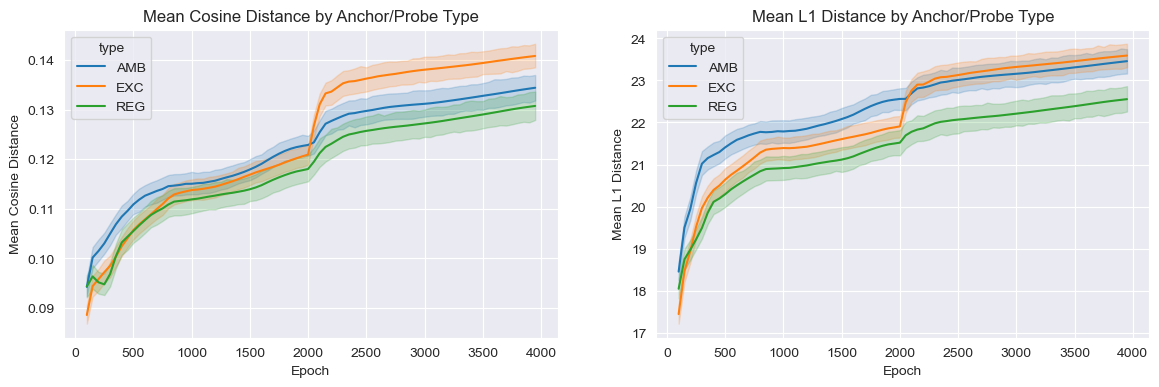

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title(f'Mean Cosine Distance by {TYPE.title()} Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title(f'Mean L1 Distance by {TYPE.title()} Type')

plt.show()

### Distance by Dilution Level (split by word type)
In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot. The three partitions are grouped together.

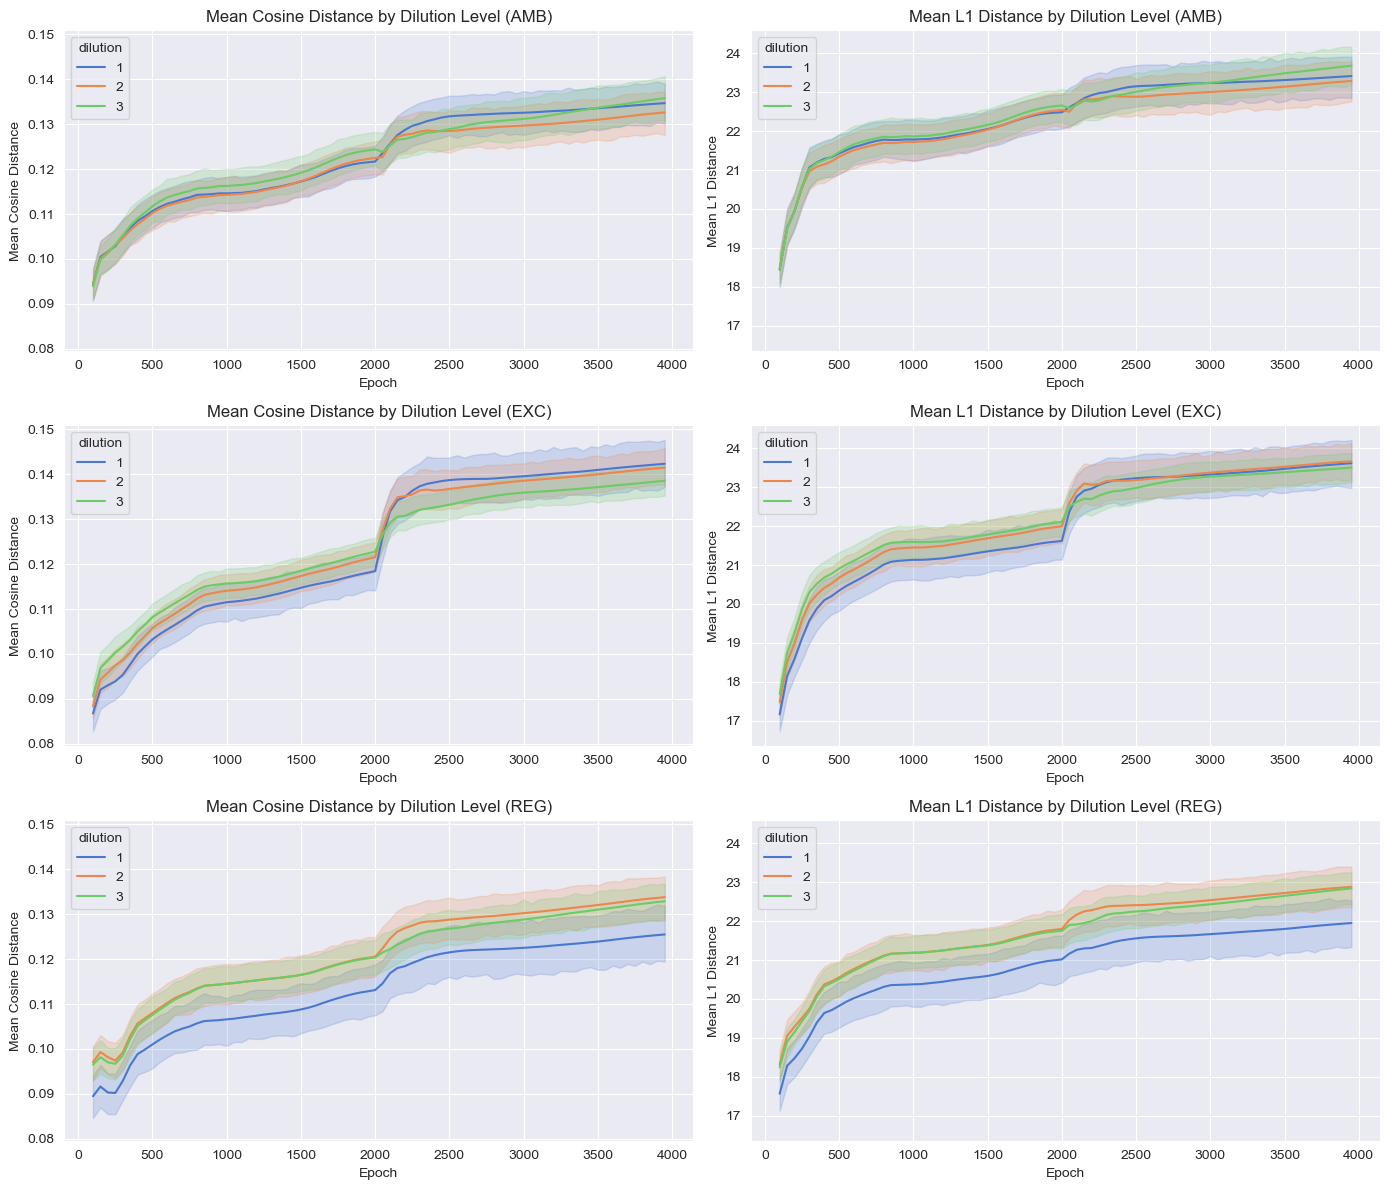

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

### Distance by Regularity Type (split by Dilution Level)
In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot. The three partitions are grouped together.

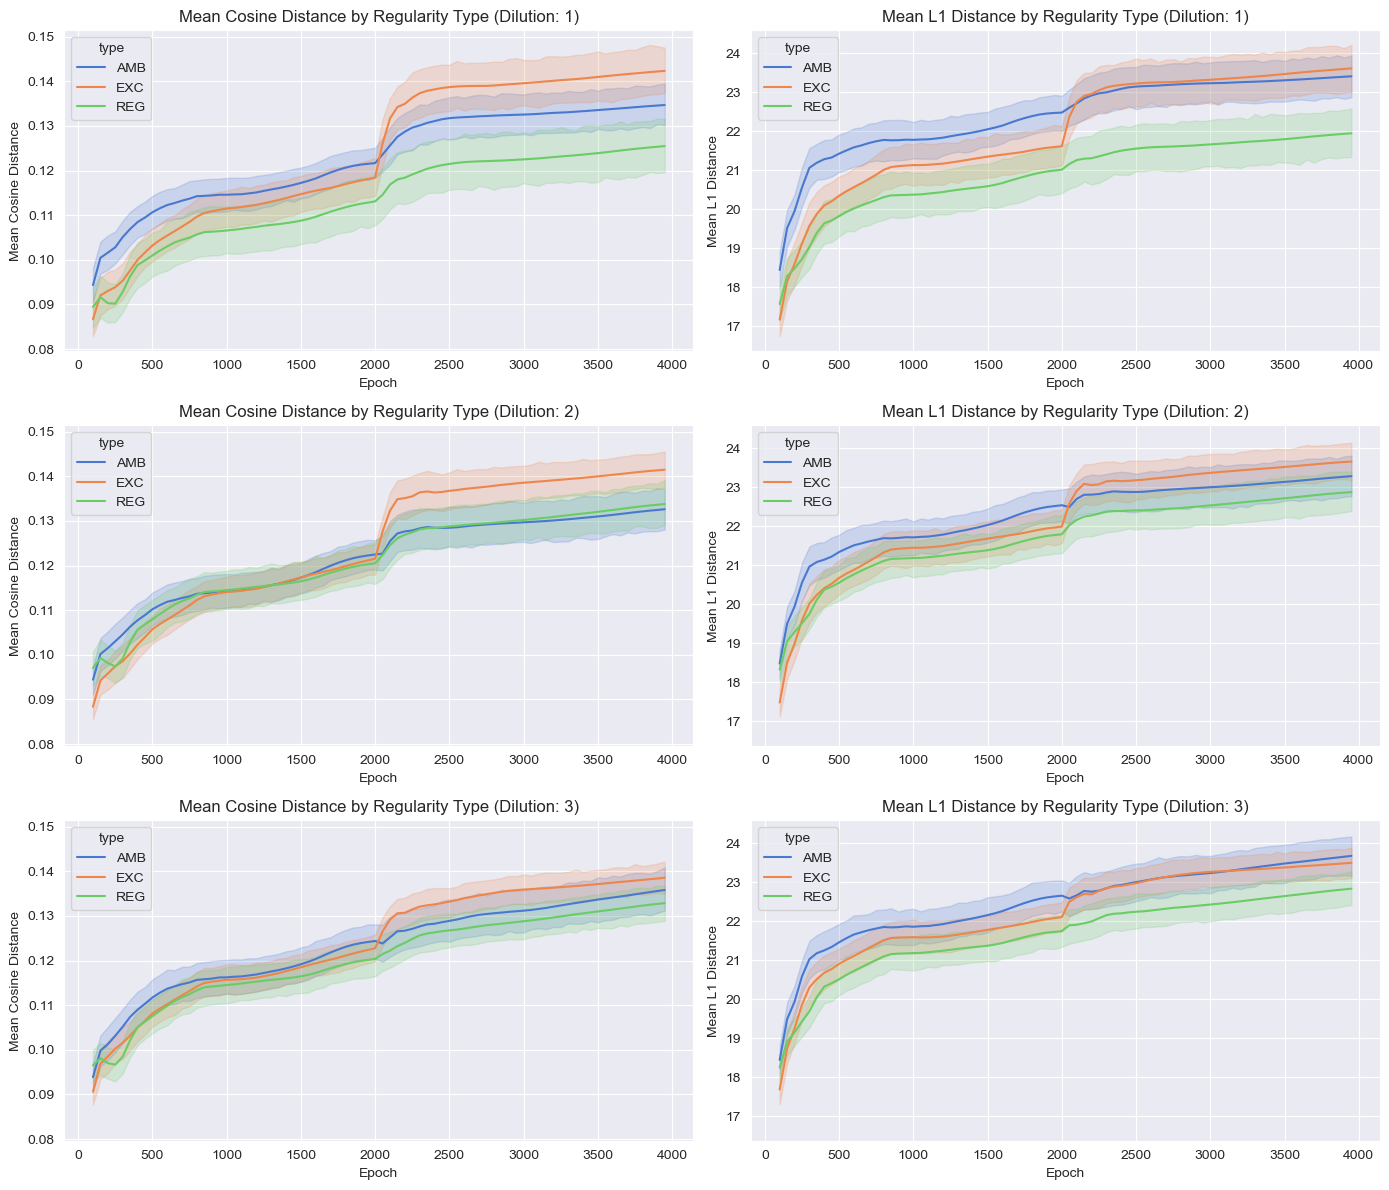

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

### Dilution Level 1 by Word Type
In the next 3 sets of graphs, we look at each **partition** level individually for dilution level 1, but combine all three regularity types in the same plot. The three partitions are grouped together.

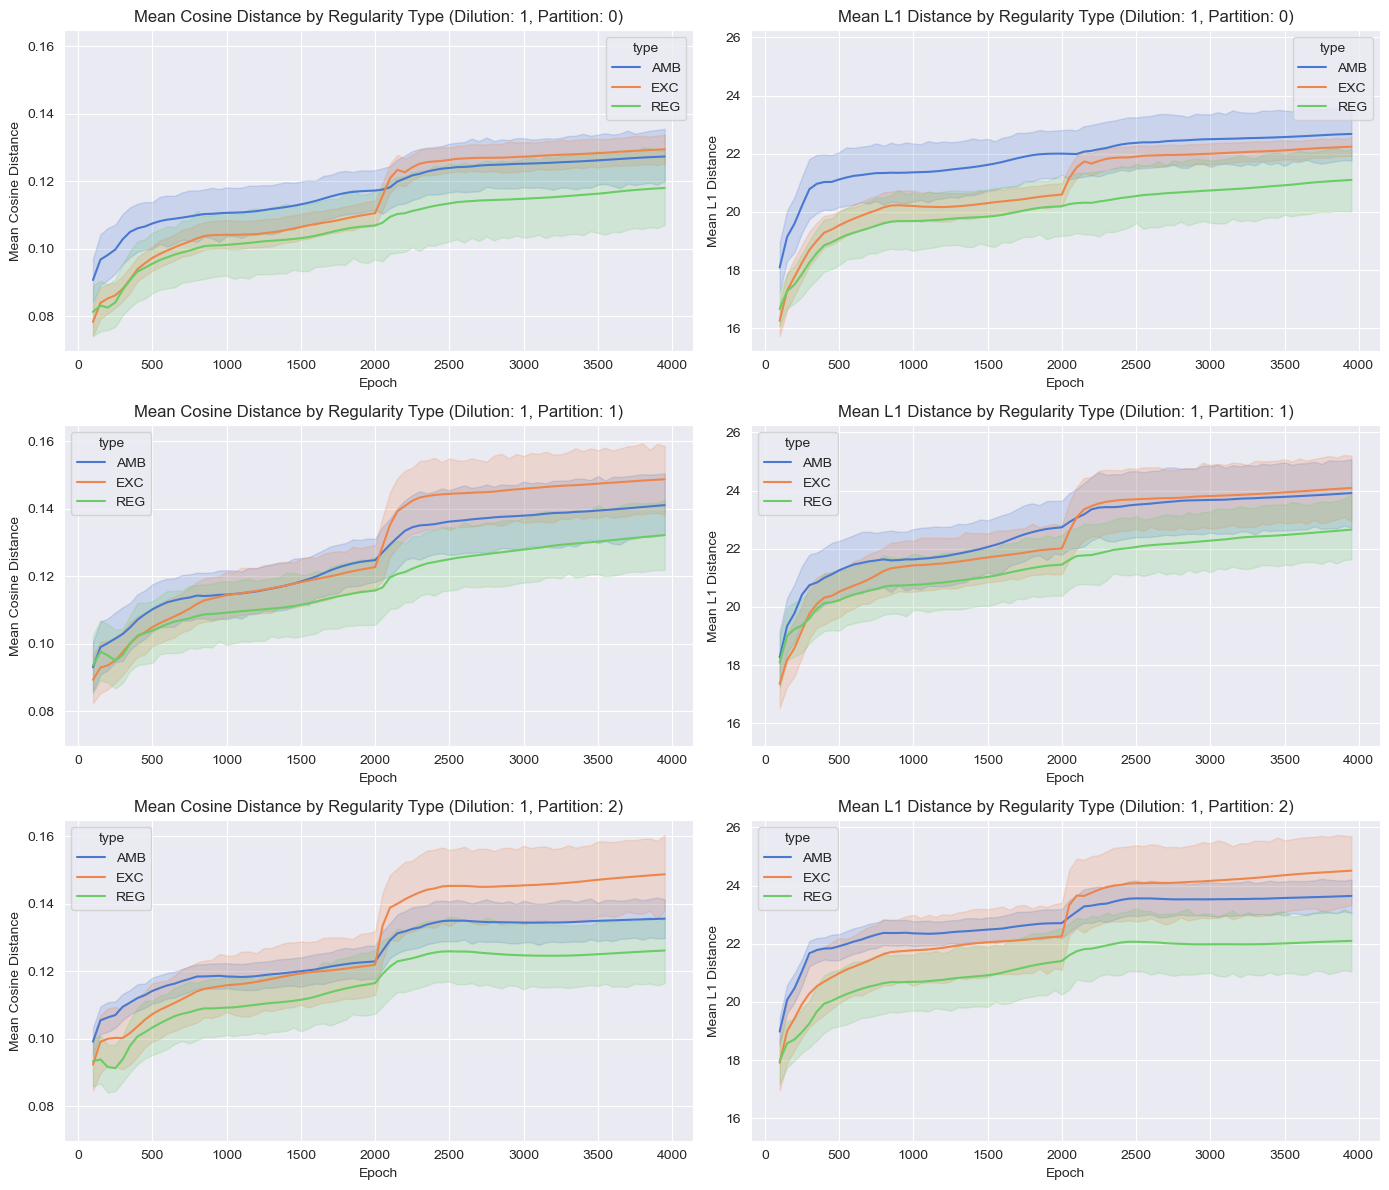

In [15]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')
dilution = 1
temp_results = results_df[results_df['dilution'] == dilution]

for partition, ax in zip(sorted(temp_results['partition'].unique()), axs):
    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

plt.tight_layout()
plt.show()

### Dilution Level 2 by Word Type
In the next 3 sets of graphs, we look at each **partition** level individually for dilution level 2, but combine all three regularity types in the same plot. The three partitions are grouped together.

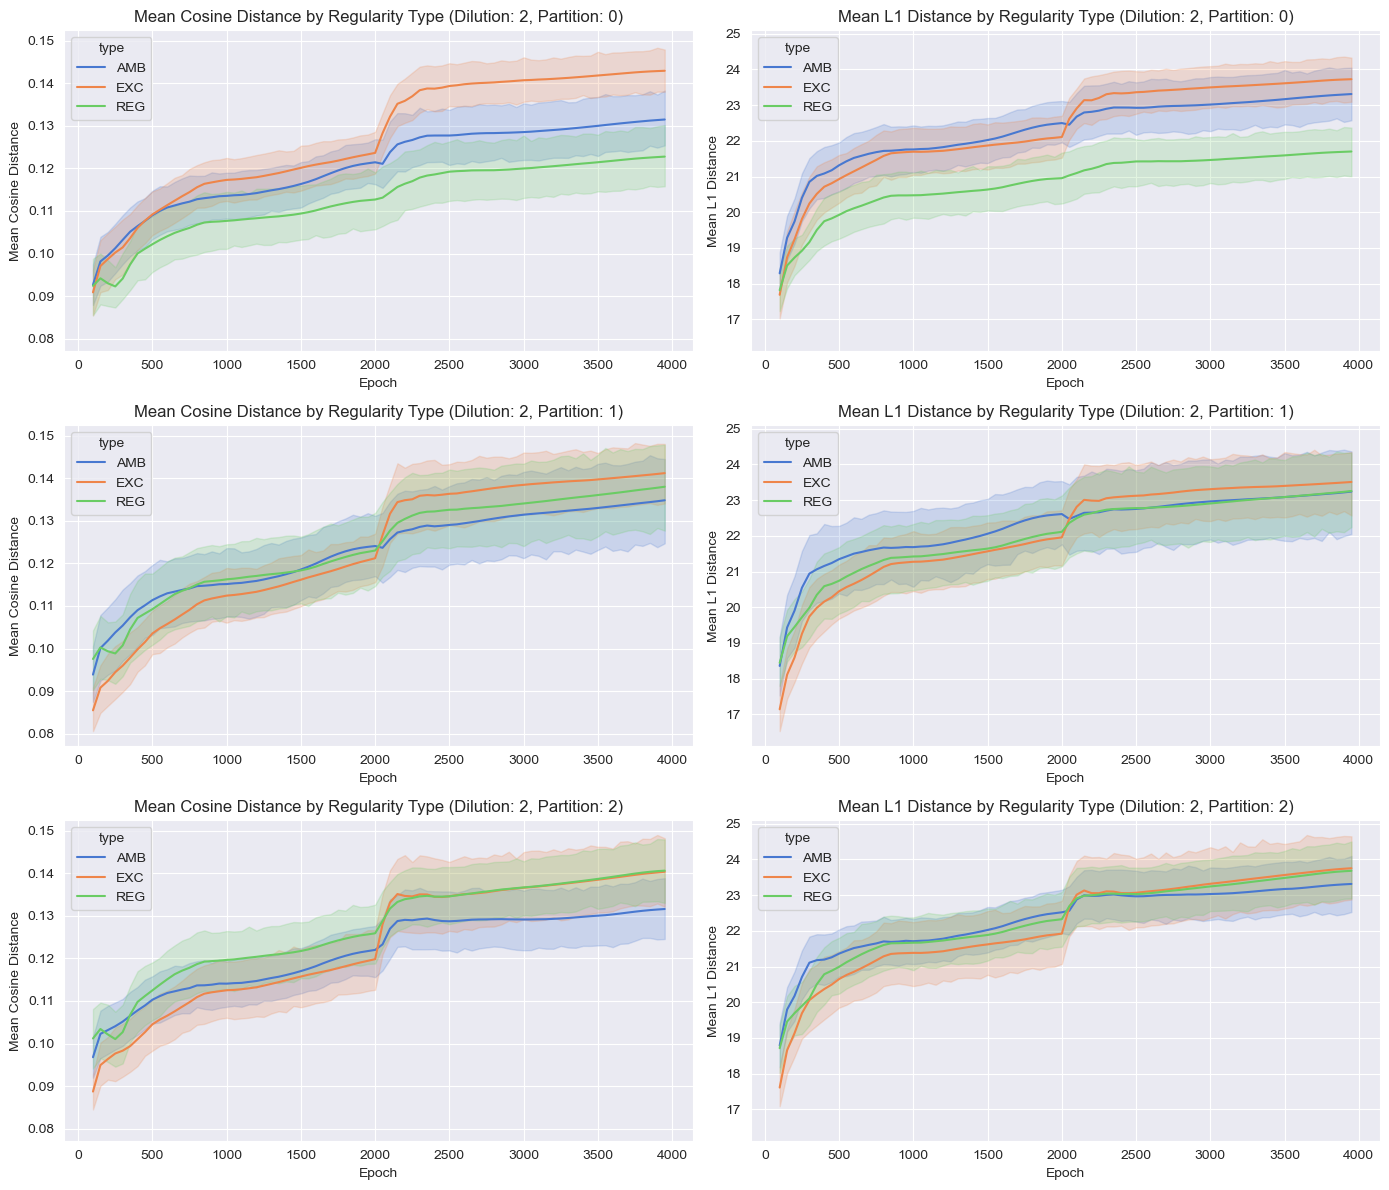

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')
dilution = 2
temp_results = results_df[results_df['dilution'] == dilution]

for partition, ax in zip(sorted(temp_results['partition'].unique()), axs):
    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

plt.tight_layout()
plt.show()

### Dilution Level 3 by Word Type
In the next 3 sets of graphs, we look at each **partition** level individually for dilution level 3, but combine all three regularity types in the same plot. The three partitions are grouped together.

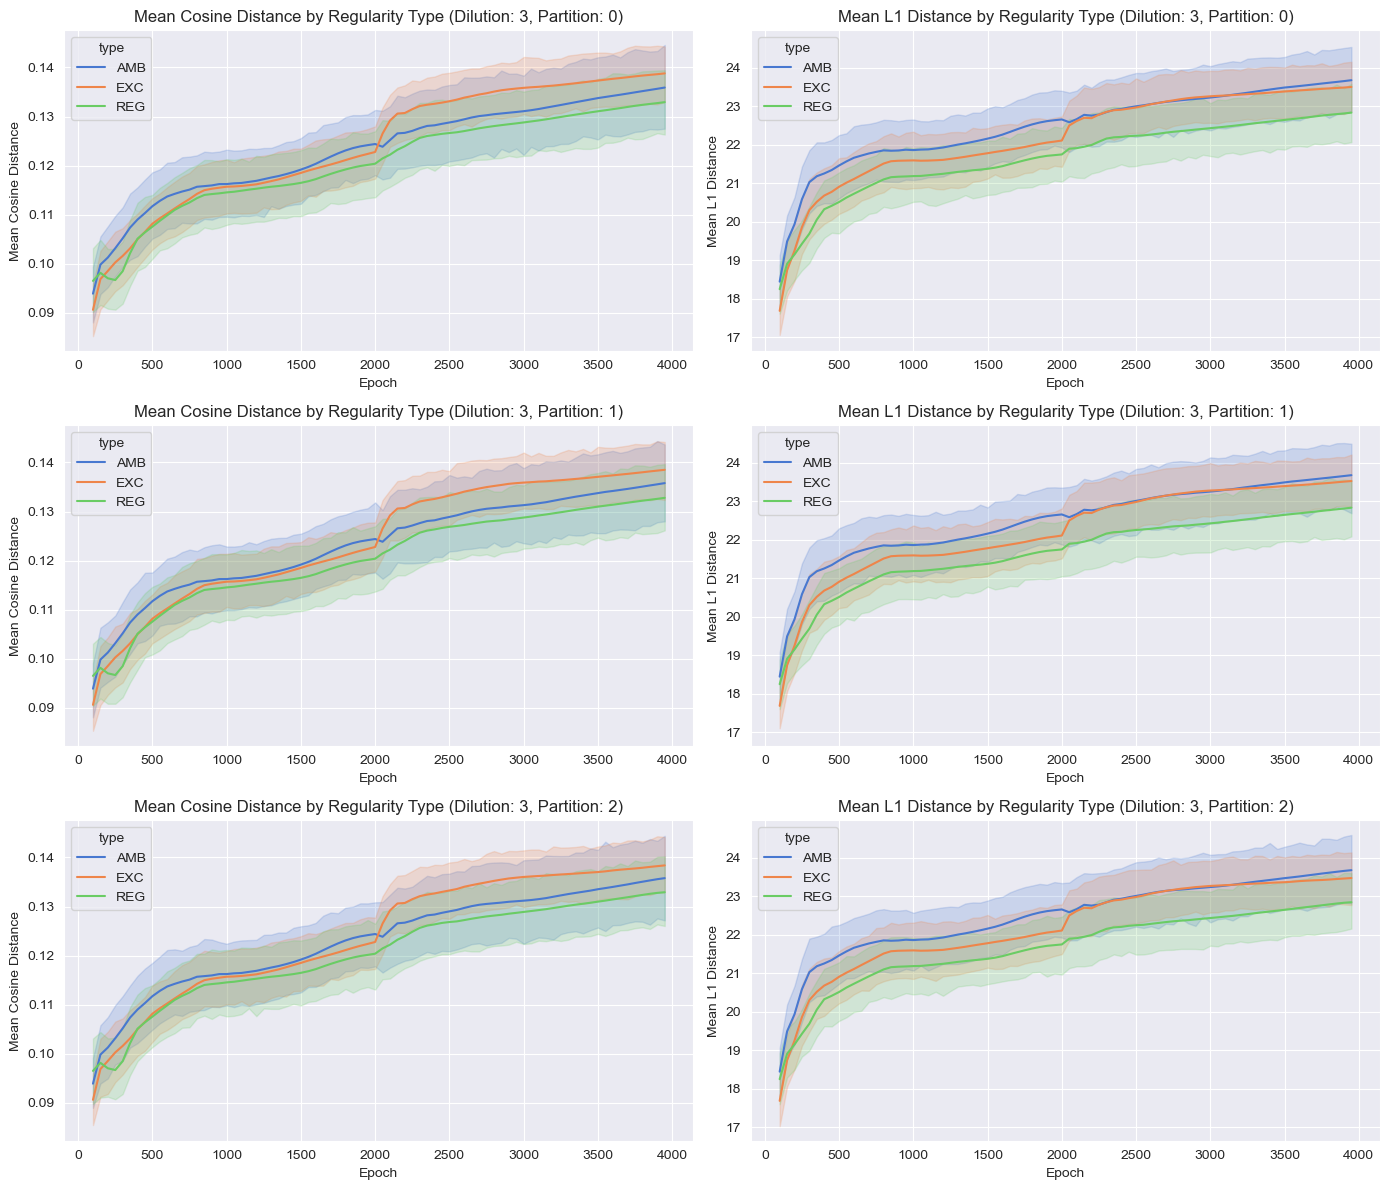

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')
dilution = 3
temp_results = results_df[results_df['dilution'] == dilution]

for partition, ax in zip(sorted(temp_results['partition'].unique()), axs):
    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

    sns.lineplot(data=temp_results[temp_results['partition'] == partition], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution}, Partition: {partition})')

plt.tight_layout()
plt.show()

## Distance by Word Set
* We refer to each anchor/probe set by the first anchor/probe.

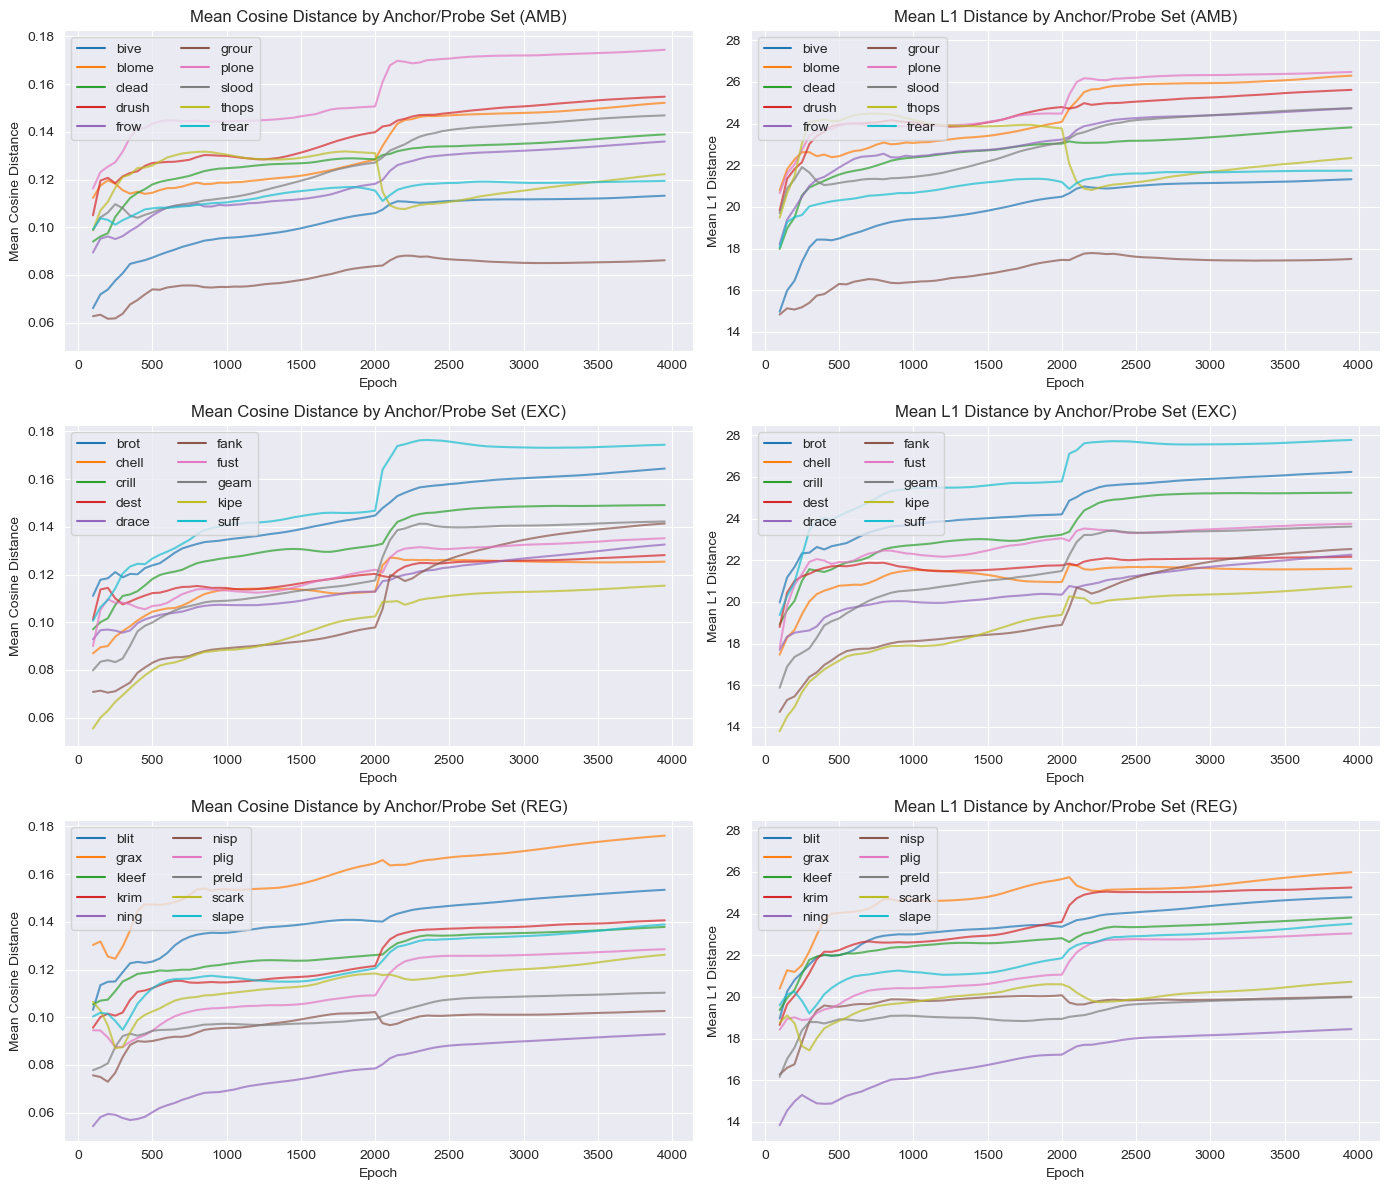

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by {TYPE.title()} Set ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by {TYPE.title()} Set ({word_type})')

plt.tight_layout()
plt.show()